In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
import numpy as np
import time
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plot

In [2]:
batch_size = 128
learning_rate = 0.001
epochs = 23

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000
Size: (3, 32, 32)


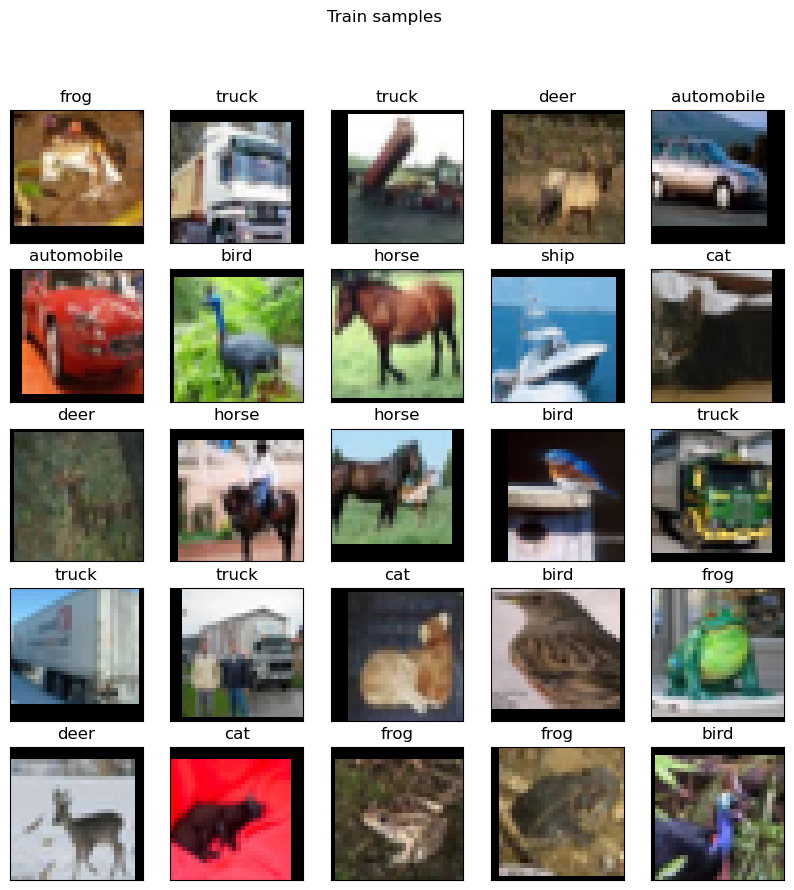

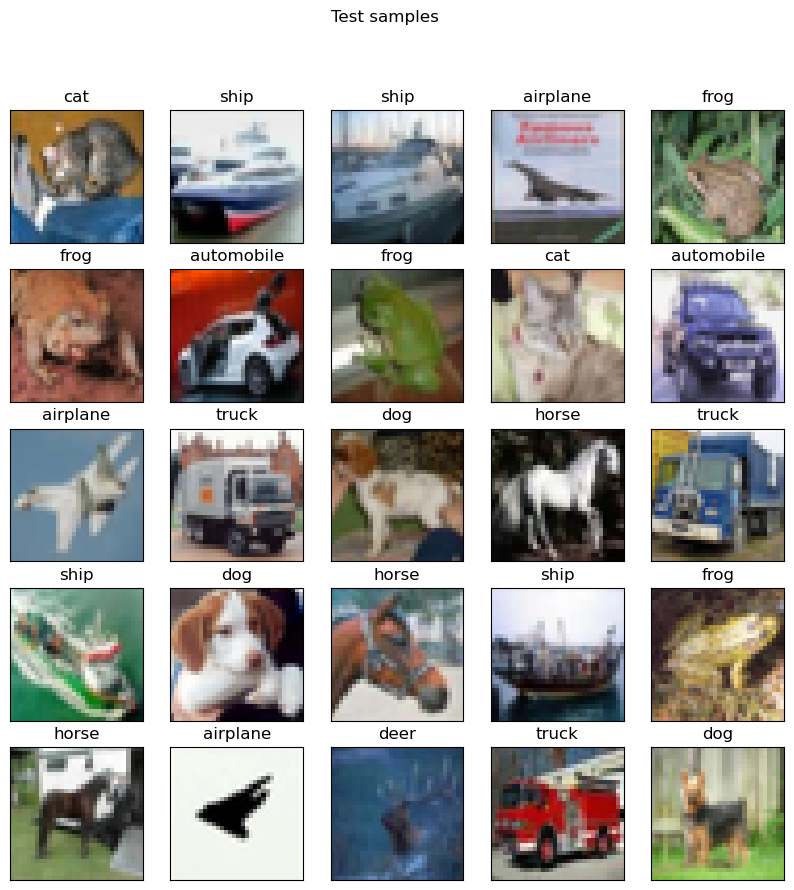

In [3]:
dir_name = os.getcwd()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

means_stds = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

def show_images(images, title):
    num_showed_imgs_x = 5
    num_showed_imgs_y = 5

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        means = torch.tensor(means_stds[0]).reshape(3, 1, 1)
        stds = torch.tensor(means_stds[1]).reshape(3, 1, 1)
        img = images[i][0] * stds + means
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.set_title(train_dataset.classes[images[i][1]])

        
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*means_stds),
])

transforms_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*means_stds)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(dir_name, train=True, download=True,
    transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(dir_name, train=False, download=True,
    transform = transforms_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

print('Size: {}'.format(train_dataset[0][0].numpy().shape))

# Сверточная сеть

In [4]:
def layers(in_channels, out_channels):
    return [torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            torch.nn.BatchNorm2d(out_channels), 
            torch.nn.ReLU(inplace=True)]

class ResNet9(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 =  torch.nn.Sequential(*layers(in_channels, 64))
        self.conv2 = torch.nn.Sequential(*layers(64, 128), torch.nn.MaxPool2d(2))
        self.res1 = torch.nn.Sequential(*layers(128, 128), *layers(128, 128))
        
        self.conv3 = torch.nn.Sequential(*layers(128, 256), torch.nn.MaxPool2d(2))
        self.conv4 = torch.nn.Sequential(*layers(256, 512), torch.nn.MaxPool2d(2))
        self.res2 = torch.nn.Sequential(*layers(512, 512), *layers(512, 512))
        
        self.classifier = torch.nn.Sequential(
            torch.nn.MaxPool2d(3), 
			torch.nn.Flatten(), 
			torch.nn.Dropout(0.2),
			torch.nn.Linear(512, num_classes)
		)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
    
cnn_model = ResNet9(3, 10)
cnn_model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, ker


(process:6968): Pango-WARNING **: 23:15:49.026: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


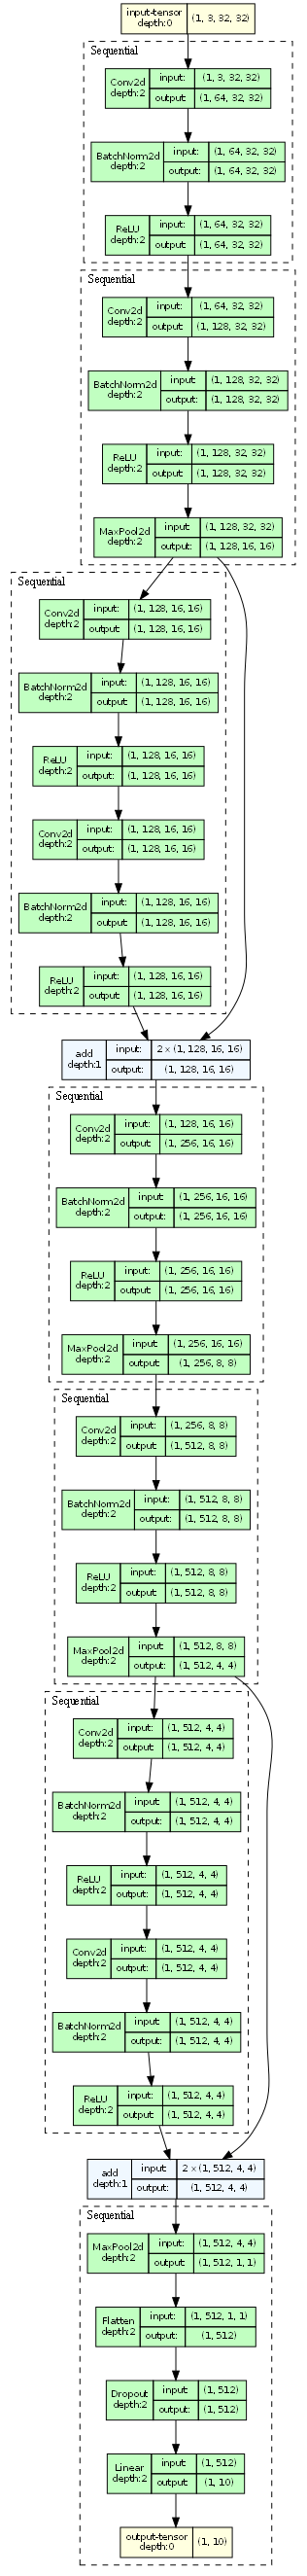

In [5]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(cnn_model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)

cuda:0


In [7]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad(): # деактивация вычисления градиентов
        for images, labels in data_loader: # проход по всем данным
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum() # количество совпадений
    return tp / n

learning_start_time = time.time()
for epoch in range(epochs):  # проход по эпохам
    start = time.time()
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Прямой проход
        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        losses.append(loss)

        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    duration = time.time() - start
    print('Epoch[{}]: loss = {}, accuracy = {}, time = {}'.format(epoch, torch.stack(losses).mean(), get_accuracy(train_loader, cnn_model), duration))

print('Total time: {}'.format(time.time() - learning_start_time))

Epoch[0]: loss = 1.352250576019287, accuracy = 0.6746999621391296, time = 31.812301874160767
Epoch[1]: loss = 0.7968270778656006, accuracy = 0.769279956817627, time = 31.894104719161987
Epoch[2]: loss = 0.6383993029594421, accuracy = 0.808139979839325, time = 32.27821397781372
Epoch[3]: loss = 0.5438697338104248, accuracy = 0.8420199751853943, time = 32.23917484283447
Epoch[4]: loss = 0.4709569811820984, accuracy = 0.8608399629592896, time = 31.82044816017151
Epoch[5]: loss = 0.424018919467926, accuracy = 0.8747999668121338, time = 31.857184648513794
Epoch[6]: loss = 0.37857431173324585, accuracy = 0.8700199723243713, time = 31.835041522979736
Epoch[7]: loss = 0.3528759181499481, accuracy = 0.8888999819755554, time = 31.8174090385437
Epoch[8]: loss = 0.32042640447616577, accuracy = 0.9053199887275696, time = 31.816693782806396
Epoch[9]: loss = 0.2943877875804901, accuracy = 0.9072200059890747, time = 31.90543508529663
Epoch[10]: loss = 0.2759343087673187, accuracy = 0.911139965057373, 

In [11]:
def get_loss(model, data_loader):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

print('loss = {}, test accuracy = {}'.format(get_loss(cnn_model, test_loader), get_accuracy(test_loader, cnn_model)))

loss = 0.003063804004341364, test accuracy = 0.890999972820282
